# MountainCar with Twin Delayed DDPG (TD3)

### Paper: https://arxiv.org/abs/1802.09477


### 1. Start the Environment and Agent 

In [1]:
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F

import gym
## import os

import time
from TwinDelayed import Actor, Critic, ReplayBuffer, TD3
from collections import deque


device:  cpu


/home/rafaels/ml-agents/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
start_timestep=1e4

std_noise=0.03

env = gym.make('MountainCarContinuous-v0')
seed = 12345
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
threshold = env.spec.reward_threshold

print('start_dim: ', state_dim, ', action_dim: ', action_dim)
print('max_action: ', max_action, ', threshold: ', threshold)

agent = TD3(state_dim, action_dim, max_action)

dir_chk = 'dir_mcar_td3'

start_dim:  2 , action_dim:  1
max_action:  1.0 , threshold:  90.0


### 2. Traning the agent

In [3]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, filename, directory):
    torch.save(agent.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(agent.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_t.pth' % (directory, filename))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_t.pth' % (directory, filename))   

In [4]:
# Twin Delayed Deep Deterministic (TD3) policy gradient algorithm
def twin_ddd_train(n_episodes=50000, save_every=100, print_env=10):

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    time_start = time.time()                    # Init start time
    replay_buf = ReplayBuffer()                 # Init ReplayBuffer
    
    timestep_after_last_save = 0
    total_timesteps = 0
    
    low = env.action_space.low
    high = env.action_space.high
    
    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)
            
    for i_episode in range(1, n_episodes+1):
        
        timestep = 0
        total_reward = 0
        
        # Reset environment
        state = env.reset()
        done = False
        
        while True:
            
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0: 
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)
            
            # Perform action
            new_state, reward, done, _ = env.step(action) 
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.add((state, new_state, action, reward, done_bool))
            state = new_state

            timestep += 1     
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        max_score = np.max(scores_deque)
        
        # train_by_episode(time_start, i_episode) 
        s = (int)(time.time() - time_start)
        if i_episode % print_env == 0 or (len(scores_deque) == 100 and avg_score > threshold):
            print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.3f}, Max.Score: {:.2f},  Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, max_score, s//3600, s%3600//60, s%60))     

        agent.train(replay_buf, timestep)

        if i_episode % save_every == 0 and i_episode > 0:

            timestep_after_last_save %= save_every            
            save(agent, 'weights', dir_chk)  
        
        if len(scores_deque) == 100 and avg_score >= threshold:
            print('Environment solved with Average Score: ',  avg_score )
            break 

    return scores_array, avg_scores_array

scores, avg_scores = twin_ddd_train()

Low in action space:  [-1.] , High:  [1.] , Action_dim:  1
Ep. 10, Timestep 9990,  Ep.Timesteps 999, Score: -32.86, Avg.Score: -33.144, Max.Score: -31.67,  Time: 00:02:13 
Ep. 20, Timestep 19980,  Ep.Timesteps 999, Score: -0.09, Avg.Score: -21.510, Max.Score: -0.09,  Time: 00:04:48 
Ep. 30, Timestep 29970,  Ep.Timesteps 999, Score: -0.11, Avg.Score: -14.375, Max.Score: -0.09,  Time: 00:07:24 
Ep. 40, Timestep 39960,  Ep.Timesteps 999, Score: -0.11, Avg.Score: -10.806, Max.Score: -0.09,  Time: 00:10:07 
Ep. 50, Timestep 49950,  Ep.Timesteps 999, Score: -0.10, Avg.Score: -8.666, Max.Score: -0.08,  Time: 00:13:06 
Ep. 60, Timestep 59940,  Ep.Timesteps 999, Score: -0.11, Avg.Score: -7.241, Max.Score: -0.08,  Time: 00:16:27 
Ep. 70, Timestep 69930,  Ep.Timesteps 999, Score: -0.10, Avg.Score: -6.221, Max.Score: -0.08,  Time: 00:20:37 
Ep. 80, Timestep 79920,  Ep.Timesteps 999, Score: -0.09, Avg.Score: -5.456, Max.Score: -0.08,  Time: 00:25:48 
Ep. 90, Timestep 89910,  Ep.Timesteps 999, Score

Ep. 740, Timestep 739260,  Ep.Timesteps 999, Score: -0.19, Avg.Score: -0.168, Max.Score: -0.08,  Time: 07:18:50 
Ep. 750, Timestep 749250,  Ep.Timesteps 999, Score: -0.17, Avg.Score: -0.178, Max.Score: -0.09,  Time: 07:25:12 
Ep. 760, Timestep 759240,  Ep.Timesteps 999, Score: -0.23, Avg.Score: -0.181, Max.Score: -0.09,  Time: 07:31:35 
Ep. 770, Timestep 769230,  Ep.Timesteps 999, Score: -0.24, Avg.Score: -0.185, Max.Score: -0.09,  Time: 07:37:57 
Ep. 780, Timestep 779220,  Ep.Timesteps 999, Score: -0.10, Avg.Score: -0.187, Max.Score: -0.09,  Time: 07:44:19 
Ep. 790, Timestep 789210,  Ep.Timesteps 999, Score: -0.24, Avg.Score: -0.189, Max.Score: -0.09,  Time: 07:50:42 
Ep. 800, Timestep 799200,  Ep.Timesteps 999, Score: -0.20, Avg.Score: -0.193, Max.Score: -0.09,  Time: 07:57:04 
Ep. 810, Timestep 809190,  Ep.Timesteps 999, Score: -0.19, Avg.Score: -0.190, Max.Score: -0.10,  Time: 08:03:27 
Ep. 820, Timestep 819180,  Ep.Timesteps 999, Score: -0.18, Avg.Score: -0.189, Max.Score: -0.10, 

In [5]:
save(agent, 'final', dir_chk)  

length of scores:  1156 , len of avg_scores:  1156


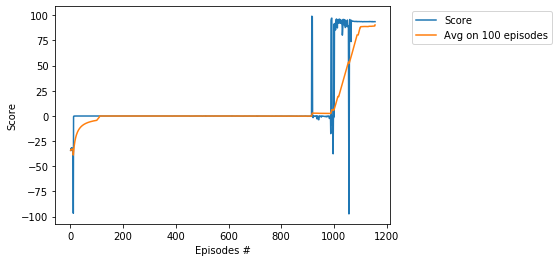

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action = agent.select_action(np.array(state))
            env.render()
            time.sleep(0.01)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))  

play(env=env, agent=agent, n_episodes=10)


In [ ]:
env.close()